In [1]:
import numpy as np
from src.LinModel import *
from src.analysis import *
from src.regression import *
from src.utils import gen_utils
from src.plotter import *
from src.CURBD.CurbdModel import *
from itertools import product
from tqdm.notebook import tqdm

%load_ext autoreload 
%autoreload 2
%matplotlib widget

# Demo of main analyses on single recording session and single simulated session. Approximate run-time: 5 minutes. Installation instructions in README.md of repo.

# Linear Regularization Sweep, Actual Recording

In [2]:
session = pload('data/co9_LinModel.pickle') #load mouse session

## split up data segments for N and PN models

In [3]:
post=45
binsize=10
nlags=5
pre=binsize*nlags
num_PCs=20
sw_weight=50

random_state=1
rng = np.random.default_rng(random_state)

if num_PCs is None:
    num_region1 = session.num_region1
else:
    num_region1 = num_PCs


laser_bounds, ctrl_bounds = session.adjustLaserBounds(pre=pre, post=post)
train_lasers, test_lasers = train_test_split(laser_bounds, train_size=.8,
        random_state=random_state)
omit_lasers, _ = session.adjustLaserBounds(pre=0, post=300)
temp_mask = rng.choice(len(ctrl_bounds), len(test_lasers), replace=False)
ctrl_bounds_subsamp = ctrl_bounds[temp_mask, :]
both_bounds = np.vstack((test_lasers, ctrl_bounds_subsamp))
train_lasers = np.sort(train_lasers, axis=0)
test_lasers = np.sort(test_lasers, axis=0)
both_bounds = np.sort(both_bounds, axis=0)
omitLaserBounds= omitBoundInBounds(session.climbing_bounds, test_lasers)
omitLaserBounds = omitBoundInBounds(omitLaserBounds, ctrl_bounds)
omitLaserBounds = minimumBoundSize(omitLaserBounds, min_size = post+pre) #segments for PN models
justClimbs = omitBoundInBounds(session.climbing_bounds, omit_lasers)
justClimbs = omitBoundInBounds(justClimbs, ctrl_bounds)
justClimbs = minimumBoundSize(justClimbs, min_size=post+pre) #segments for N models

## generate train and test data

In [4]:
sws = session.getSWs(bigBound=omitLaserBounds, smallBound=train_lasers,
        sw_weight=sw_weight, binsize=binsize, nlags=nlags)

(X_n, Y_n), n_PCs = session.generate_trainset(justClimbs, binsize=binsize,
        nlags=nlags, num_PCs=num_PCs)

(X_pn, Y_pn), pn_PCs = session.generate_trainset(omitLaserBounds, binsize=binsize,
        nlags=nlags, num_PCs=num_PCs)


X_nt, Y_nt = session.generate_testset(bounds=ctrl_bounds, binsize=binsize,
    nlags=nlags, PCAObjs = n_PCs)
X_pnt, Y_pnt = session.generate_testset(bounds=both_bounds, binsize=binsize,
    nlags=nlags, PCAObjs = pn_PCs)

fitting and applyingPCA
fitting and applyingPCA
applying PCA
applying PCA


## generate regularization parameters

In [5]:
ustream = np.logspace(4,6,8)
dstream = np.logspace(4,6,8)
reg_combos = list(product(dstream, ustream))

## start sweep, should be <2 minutes to run

In [6]:
n_rqs=[]
n_r2s=[]

pn_rqs=[]
pn_r2s=[]
for reg in tqdm(reg_combos):
    c = generate_sepreg(reg, X_n, nlags=nlags, num_region1=num_region1)
    h_n = train_wiener_filter(X_n, Y_n, c=c,sw=None, display=False) #fit regression
    h_pn=train_wiener_filter(X_pn, Y_pn, c=c,sw=sws, display=False) #fit regression
    
    n_rqs.append(session.get_relative_drive(h_n, X_nt, nlags=nlags,
                                      num_region1=num_region1))
    pn_rqs.append(session.get_relative_drive(h_pn, X_pnt, nlags=nlags,
                                       num_region1=num_region1))
    
    yhat_n = test_wiener_filter(X_nt, h_n)
    n_r2s.append(weighted_r2(Y_nt, yhat_n))

    yhat_pn = test_wiener_filter(X_pnt, h_pn)
    pn_r2s.append(weighted_r2(Y_pnt, yhat_pn))



  0%|          | 0/64 [00:00<?, ?it/s]

## showing top N models

(0.15, 0.35)

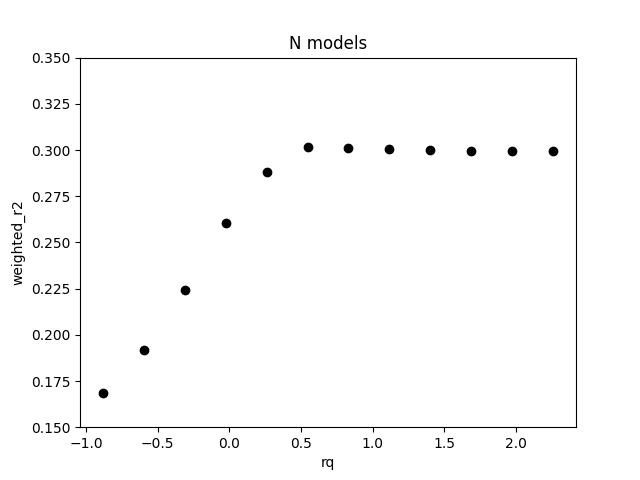

In [7]:
fig,ax = plt.subplots()
n_rqs_top, n_r2s_top, _, _ = get_top_models(n_rqs, n_r2s, num_bins=12, evenspace=True) #get top models for visualization purposes
ax.set_title('N models')
ax.scatter(n_rqs_top, n_r2s_top, color='black')
ax.set_xlabel('rq')
ax.set_ylabel('weighted_r2')
ax.set_ylim(.15,.35)


## showing top PN models

(0.15, 0.35)

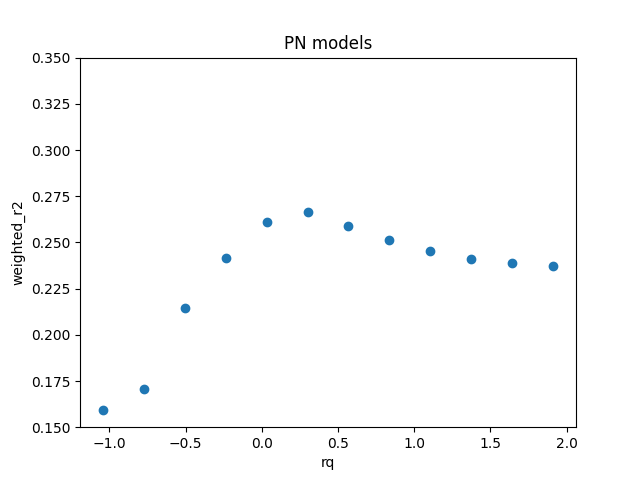

In [8]:
fig,ax = plt.subplots()
pn_rqs_top, pn_r2s_top, _, _ = get_top_models(pn_rqs, pn_r2s, num_bins=12, evenspace=True) #get top models for visualization purposes
ax.scatter(pn_rqs_top, pn_r2s_top, color='tab:blue')
ax.set_title('PN models')
ax.set_xlabel('rq')
ax.set_ylabel('weighted_r2')
ax.set_ylim(.15,.35)

# Linear Regularization Sweep, Simulated Data

In [9]:
session = pload('data/cu9_sim_LinModel.pickle') #lin model on sim data
true_rnn = CurbdModel(pload('data/cu9_rnn.pickle')) #true RNN, needed for true RQ

/home/diya/anaconda3/envs/opto_constrain/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


contains sim data already


## segment data and generate train/test sets

In [10]:
post=45
binsize=10
nlags=5
pre=binsize*nlags
num_PCs=20
sw_weight=50

random_state=1
rng = np.random.default_rng(random_state)

if num_PCs is None:
    num_region1 = session.num_region1
else:
    num_region1 = num_PCs


laser_bounds, ctrl_bounds = session.adjustLaserBounds(pre=pre, post=post)
train_lasers, test_lasers = train_test_split(laser_bounds, train_size=.8,
        random_state=random_state)
omit_lasers, _ = session.adjustLaserBounds(pre=0, post=300)
temp_mask = rng.choice(len(ctrl_bounds), len(test_lasers), replace=False)
ctrl_bounds_subsamp = ctrl_bounds[temp_mask, :]
both_bounds = np.vstack((test_lasers, ctrl_bounds_subsamp))
train_lasers = np.sort(train_lasers, axis=0)
test_lasers = np.sort(test_lasers, axis=0)
both_bounds = np.sort(both_bounds, axis=0)
omitLaserBounds= omitBoundInBounds(session.climbing_bounds, test_lasers)
omitLaserBounds = omitBoundInBounds(omitLaserBounds, ctrl_bounds)
omitLaserBounds = minimumBoundSize(omitLaserBounds, min_size = post+pre) #segments for PN models
justClimbs = omitBoundInBounds(session.climbing_bounds, omit_lasers)
justClimbs = omitBoundInBounds(justClimbs, ctrl_bounds)
justClimbs = minimumBoundSize(justClimbs, min_size=post+pre) #segments for N models

sws = session.getSWs(bigBound=omitLaserBounds, smallBound=train_lasers,
        sw_weight=sw_weight, binsize=binsize, nlags=nlags)

(X_n, Y_n), n_PCs = session.generate_trainset(justClimbs, binsize=binsize,
        nlags=nlags, num_PCs=num_PCs)

(X_pn, Y_pn), pn_PCs = session.generate_trainset(omitLaserBounds, binsize=binsize,
        nlags=nlags, num_PCs=num_PCs)

d, u, decay = true_rnn.relative_J(bounds=both_bounds, binsize=binsize, nlags=nlags)
pn_true_rq = np.log10((d+decay)/u)
d, u, decay = true_rnn.relative_J(bounds=ctrl_bounds, binsize=binsize, nlags=nlags)
n_true_rq = np.log10((d+decay)/u)


X_nt, Y_nt = session.generate_testset(bounds=ctrl_bounds, binsize=binsize,
    nlags=nlags, PCAObjs = n_PCs)
X_pnt, Y_pnt = session.generate_testset(bounds=both_bounds, binsize=binsize,
    nlags=nlags, PCAObjs = pn_PCs)

fitting and applyingPCA
fitting and applyingPCA
0.3282475212240337
0.7958702600261606
applying PCA
applying PCA


## run sweep

In [11]:
ustream = np.logspace(4,8,8)
dstream = np.logspace(4,8,8)
reg_combos = list(product(dstream, ustream))

n_rqs=[]
n_r2s=[]

pn_rqs=[]
pn_r2s=[]
for reg in tqdm(reg_combos):
    c = generate_sepreg(reg, X_n, nlags=nlags, num_region1=num_region1)
    h_n = train_wiener_filter(X_n, Y_n, c=c,sw=None, display=False) #fit regression
    h_pn=train_wiener_filter(X_pn, Y_pn, c=c,sw=sws, display=False) #fit regression
    
    n_rqs.append(session.get_relative_drive(h_n, X_nt, nlags=nlags,
                                      num_region1=num_region1))
    pn_rqs.append(session.get_relative_drive(h_pn, X_pnt, nlags=nlags,
                                       num_region1=num_region1))
    
    yhat_n = test_wiener_filter(X_nt, h_n)
    n_r2s.append(weighted_r2(Y_nt, yhat_n))

    yhat_pn = test_wiener_filter(X_pnt, h_pn)
    pn_r2s.append(weighted_r2(Y_pnt, yhat_pn))

  0%|          | 0/64 [00:00<?, ?it/s]

## showing top N (sim) models

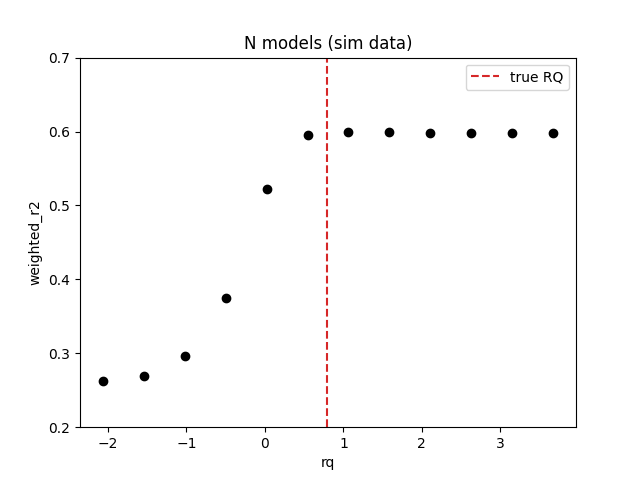

In [12]:
fig,ax = plt.subplots()
ax.set_title('N models (sim data)')
n_rqs_top, n_r2s_top, _, _ = get_top_models(n_rqs, n_r2s, num_bins=12, evenspace=True) #get top models for visualization purposes
ax.scatter(n_rqs_top, n_r2s_top, color='black')
ax.set_xlabel('rq')
ax.set_ylabel('weighted_r2')
ax.axvline(n_true_rq, linestyle='--', color='tab:red', label='true RQ')
ax.set_ylim(.2,.7)
ax.legend()

## showing top PN (sim) models

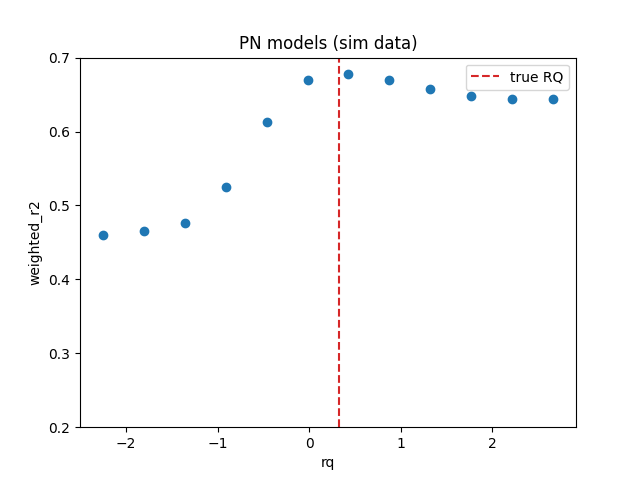

In [13]:
fig,ax = plt.subplots()
pn_rqs_top, pn_r2s_top, _, _ = get_top_models(pn_rqs, pn_r2s, num_bins=12, evenspace=True) #get top models for visualization purposes
ax.set_title('PN models (sim data)')
ax.scatter(pn_rqs_top, pn_r2s_top, color='tab:blue')
ax.set_xlabel('rq')
ax.set_ylabel('weighted_r2')
ax.axvline(pn_true_rq, linestyle='--', color='tab:red', label='true RQ')
ax.set_ylim(.2,.7)
ax.legend()